## SnowEx Hackweek, 2021
### July 14-16

This is an exploration notebook for ICESat-2 over Grand Mesa
Current goals (will change with coming days)
* Work with Ben's ICESat-2 notebook
* See how much SlideRule improve things


## Meeting Notes and ToDos
July 30, 2021
* Attended by Hannah,Jessica and Shashank
* Clean up notebook, first few cells allow user to select dates, beams, DEMs
* Be flexible with track selection
* Jessica's suggestion, make several profile plots for the different ground tracks and beams
* Right now sliderule returns everything, allowing control by date, RGT, cycle and beam could streamline direct comparison with openaltimetry standard output
* Final plot right now fixes spot to match the beam returned for standard ATL08 product
* Fix datum issues, maybe provide gdalwarp option to match the reference DEM datum to that of ICESat-2 (vertical datum reference: EPSG:4979)
* Limit sampling from DEM at ATL03 points which are close to the actual surface

## Meeting Notes and ToDos
Aug 16, 2021 meeting with Shashank
* Waiting for the updates from JP that will identify beams versus spots
* Hannah keep trying the datum transformation
* Adding more analysis: residuals from the lidar
* Pulling in different segment lengths and comparing the accuracy, especially in sloped areas. How to do this repeatably?
* Add a map of locations with 3DEP 1m accuracy lidar, since this is what we'll be focused on in this notebook, including instructions and links for grabbing the data

### SlideRule Meeting 08/24

* ATL08 are uploaded for Grand Mesa in SlideRule
* Based on the Release Notes, the GTs have been added: http://icesat2sliderule.org/release_notes/release-v1-1-0/
* SlideRule can now be installed using pip or conda -> ask Shashank if I can then use conda update to get new releases.

Ask Ben for help with the comparisons - should we combine notebooks for showing the optimal segment length? Is there a way to do this in especially sloped areas to highlight the increase in accuracy for ATL06 & ATL08 using SlideRule?

In [19]:
import numpy as np
import os,sys,glob,re
import geopandas as gpd
import hvplot.xarray
import rioxarray
import s3fs
import requests
import icepyx as ipx
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import json
import sliderule
import rasterio as rio


#### Sourced from tutorials from several hackweeks 
##### All authors' code should be acknoweldged at places

In [20]:
%config InlineBackend.figure_format='retina'
#switch to widget when actually running it, 
# otherwise inline when commiting rendered version to github
#%matplotlib widget
%matplotlib inline

### Step 1: Define extent, perform icepyx query and basic visualisation of tracks over the Mesa

In [21]:
XR = [725000.0, 767000.0]
YR = [4.30e6, 4.34e6]
lonlims = [-108.408343209786, -107.90953763121124]
latlims = [38.80833384091803, 39.18014315670584]

## Perform the granule search as Ben did:
region_a = ipx.Query('ATL03', [lonlims[0], latlims[0], lonlims[1], latlims[1]], ['2018-12-01','2021-06-01'], \
                          start_time='00:00:00', end_time='23:59:59')


In [22]:
region_a.avail_granules()

{'Number of available granules': 66,
 'Average size of granules (MB)': 2207.7770514343715,
 'Total size of all granules (MB)': 145713.28539466858}

In [23]:
print(' , '.join(region_a.avail_granules(tracks=True)[0]))

1156 , 1179 , 0211 , 0295 , 0653 , 0714 , 0737 , 1156 , 1179 , 0211 , 0295 , 0653 , 0714 , 0737 , 1156 , 1179 , 0211 , 0295 , 0653 , 0714 , 1156 , 1179 , 0211 , 0295 , 0653 , 0714 , 0737 , 1156 , 1179 , 0211 , 0295 , 0653 , 0714 , 0737 , 1156 , 1179 , 0211 , 0295 , 0653 , 0714 , 0737 , 1156 , 1179 , 0211 , 0295 , 0653 , 0714 , 0737 , 1156 , 1179 , 0211 , 0653 , 0714 , 0737 , 1179 , 0211 , 0653 , 0714 , 0737 , 1156 , 1179 , 0211 , 0295 , 0653 , 0714 , 0737


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
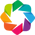

:Overlay
   .WMTS.I :WMTS   [Longitude,Latitude]
   .Path.I :Path   [Longitude,Latitude]

In [24]:
region_a.visualize_spatial_extent()

In [25]:
# Some basic exploration of granules
ATLAS_re=re.compile('ATL.._(?P<year>\d\d\d\d)(?P<month>\d\d)(?P<day>\d\d)\d+_(?P<track>\d\d\d\d)')

date_track=[]
for count, item in enumerate(region_a.granules.avail):
    granule_info=ATLAS_re.search(item['producer_granule_id']).groupdict()
    date_track += [ ('-'.join([granule_info[key] for key in ['year', 'month', 'day']]), granule_info['track'])]

# print the first ten dates and ground tracks, plus their indexes
[(count, dt) for count, dt in enumerate(date_track[0:10])]

[(0, ('2018-12-13', '1156')),
 (1, ('2018-12-14', '1179')),
 (2, ('2019-01-11', '0211')),
 (3, ('2019-01-16', '0295')),
 (4, ('2019-02-09', '0653')),
 (5, ('2019-02-13', '0714')),
 (6, ('2019-02-14', '0737')),
 (7, ('2019-03-14', '1156')),
 (8, ('2019-03-15', '1179')),
 (9, ('2019-04-12', '0211'))]

In [51]:
#dep_crs = '+proj=utm +zone=12 +datum=NAD83 +units=m +vunits=m +no_defs +geoidgrids=us_noaa_g2012bu0.tif'
dep_crs = "EPSG:6341+5703"

In [52]:
from pyproj import Transformer,CRS
#crs = CRS.from_proj('+proj=utm +zone=12 +datum=NAD83 +units=m +vunits=m +no_defs +geoidgrids=us_noaa_g2012bu0.tif')
to_dep_crs = Transformer.from_crs(4326,dep_crs)
# to_geo_crs = Transformer.from_crs(crs,crs.geodetic_crs)

In [28]:
!gdalsrsinfo '+proj=utm +zone=12 +datum=NAD83 +units=m +vunits=m +no_defs +geoidgrids=us_noaa_g2012bu0.tif'


PROJ.4 : +proj=utm +zone=12 +datum=NAD83 +units=m +geoidgrids=us_noaa_g2012bu0.tif +vunits=m +no_defs

OGC WKT2:2018 :
COMPOUNDCRS["unknown",
    PROJCRS["unknown",
        BASEGEOGCRS["unknown",
            DATUM["North American Datum 1983",
                ELLIPSOID["GRS 1980",6378137,298.257222101,
                    LENGTHUNIT["metre",1]],
                ID["EPSG",6269]],
            PRIMEM["Greenwich",0,
                ANGLEUNIT["degree",0.0174532925199433],
                ID["EPSG",8901]]],
        CONVERSION["UTM zone 12N",
            METHOD["Transverse Mercator",
                ID["EPSG",9807]],
            PARAMETER["Latitude of natural origin",0,
                ANGLEUNIT["degree",0.0174532925199433],
                ID["EPSG",8801]],
            PARAMETER["Longitude of natural origin",-111,
                ANGLEUNIT["degree",0.0174532925199433],
                ID["EPSG",8802]],
            PARAMETER["Scale factor at natural origin",0.9996,
                SCALEUNIT["

In [53]:
#### Utility functions from Ben and Philipp Arndt
# from pyproj import Transformer,CRS
# crs = CRS.from_epsg(32612)
# to_image_crs = Transformer.from_crs(crs.geodetic_crs,crs)
# to_geo_crs = Transformer.from_crs(crs,crs.geodetic_crs)

def get_OA(date_track, lonlims, latlims, beamnames=["gt1l","gt1r","gt2l","gt2r","gt3l","gt3r"],product='atl03'):
    '''
    retrieve ICESat2 ATL03 data from openAltimetry
    
    Inputs:
        date_track: a list of tuples.  Each contains a date string "YYYY-MM-DD" and track number (4-character string)
        lonlims: longitude limits for the search
        latlims: latitude limits for the search
        beamnames: list of strings for the beams
    outputs:
        a dict containing ATL03 data by beam name
    
    Due credit:
        Much of this code was borrowed Philipp Arndt's Pond Picker repo: https://github.com/fliphilipp/pondpicking
    '''
    
    
    IS2_data={}
    for this_dt in date_track:
        this_IS2_data={}
        #print(this_dt)
        for beamname in beamnames:
            oa_url = 'https://openaltimetry.org/data/api/icesat2/{product}?minx={minx}&miny={miny}&maxx={maxx}&maxy={maxy}&trackId={trackid}&beamName={beamname}&outputFormat=json&date={date}&client=jupyter'
            oa_url = oa_url.format(product=product,minx=lonlims[0],miny=latlims[0],maxx=lonlims[1], maxy=latlims[1], 
                                   trackid=this_dt[1], beamname=beamname, date=this_dt[0], sampling='true')
            #.conf_ph = ['Noise','Buffer', 'Low', 'Medium', 'High']
            if True:
                r = requests.get(oa_url)
                data = r.json()
                D={}
                D['lat_ph'] = []
                D['lon_ph'] = []
                D['h_ph'] = []
                D['conf_ph']=[]
                conf_ph = {'Noise':0, 'Buffer':1, 'Low':2, 'Medium':3, 'High':4}
                for beam in data:
                    for photons in beam['series']:
                        for conf, conf_num in conf_ph.items():         
                            if conf in photons['name']:
                                for p in photons['data']:
                                    
                                    D['lat_ph'].append(p[0])
                                    D['lon_ph'].append(p[1])
                                    D['h_ph'].append(p[2])
                                    D['conf_ph'].append(conf_num)
                    D['x_ph'], D['y_ph']=to_dep_crs.transform(D['lat_ph'], D['lon_ph'])
                for key in D:
                    D[key]=np.array(D[key])
                if len(D['lat_ph']) > 0:
                    this_IS2_data[beamname]=D
                ### write these out as netcdf files, 
            #except Exception as e:
            #    print(e)
            #    pass
        if len(this_IS2_data.keys()) > 0:
            IS2_data[this_dt] = this_IS2_data
    return IS2_data

In [54]:
#submitting all of these requests should take about 1 minute
IS2_data=get_OA(date_track, lonlims, latlims, ['gt2l'])

In [55]:
IS2_data

{('2018-12-13',
  '1156'): {'gt2l': {'lat_ph': array([39.18003607, 39.17936268, 39.17855418, ..., 38.80828626,
          38.80827986, 38.80827985]),
   'lon_ph': array([-108.04563138, -108.04571875, -108.04581871, ..., -108.09123043,
          -108.09123121, -108.09123119]),
   'h_ph': array([1898.9458, 1831.373 , 1845.3381, ..., 1627.5995, 1627.1122,
          1629.068 ]),
   'conf_ph': array([0, 0, 0, ..., 4, 4, 4]),
   'x_ph': array([755197.43462552, 755192.32321407, 755186.61370193, ...,
          752577.24912   , 752577.20395277, 752577.20587742]),
   'y_ph': array([4340914.3500207 , 4340839.35449692, 4340749.32603032, ...,
          4299522.29310764, 4299521.57995919, 4299521.57911885])}},
 ('2019-01-16',
  '0295'): {'gt2l': {'lat_ph': array([38.81901769, 38.8190271 , 38.81902928, ..., 39.17351699,
          39.1735248 , 39.17353091]),
   'lon_ph': array([-108.34645854, -108.34647938, -108.34648421, ..., -108.39008556,
          -108.3901029 , -108.39011645]),
   'h_ph': array([2

### I changed the transformer, so the ATL08 no longer matches the basemap but instead matches 3dep data.

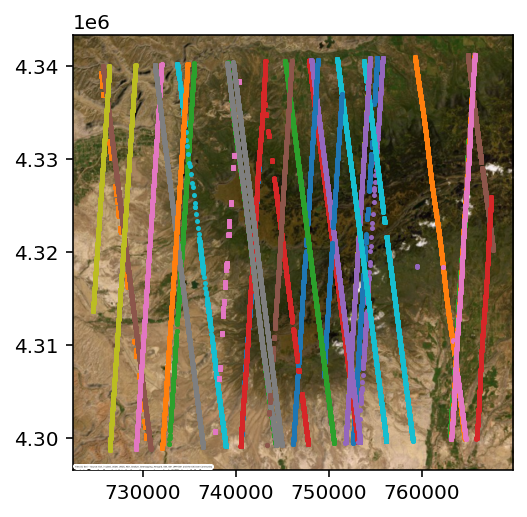

In [31]:
f,ax  = plt.subplots()
#plt.imshow(np.array(da)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])#plt.figure();

for dt, day_data in IS2_data.items():
    for beam, D in day_data.items():
        ax.plot(D['x_ph'][::10], D['y_ph'][::10], '.', markersize=3, label=int(dt[1]))
ctx.add_basemap(ax=ax,source=ctx.providers['Esri']['WorldImagery'],crs='EPSG:32612',attribution_size=0)
#ax.legend()

#### Step 2: Fetch 3DEP LiDAR (ground truth)

In [144]:
url = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/CO_MesaCo_QL2_UTM12_2016/TIFF/USGS_one_meter_x74y433_CO_MesaCo_QL2_UTM12_2016.tif'

da = rioxarray.open_rasterio(url,masked=True)
# da.hvplot.image(cmap='inferno', 
#                 x='x', y='y', 
#                 aspect='equal',
#                 title='3DEP LiDAR',
#                 rasterize=True # send rendered image to browser, rather than full array
#                )

In [145]:
da2 = rio.open(url)

In [34]:
da2.crs

CRS.from_epsg(26912)

In [35]:
da.rio.crs

CRS.from_epsg(26912)

In [36]:
da.rio?

Type:        RasterArray
String form: <rioxarray.raster_array.RasterArray object at 0x7fdc04071e20>
File:        ~/opt/miniconda3/envs/datum_reproj/lib/python3.8/site-packages/rioxarray/raster_array.py
Docstring:   This is the GIS extension for :obj:`xarray.DataArray`


#### My next steps:
* Reproject from 26912 to 32612
* Use gdal geoid that shashank sent me in slack: dem_geoid --reverse-adjustment input_dem.tif
* Look into other gdal code he sent above that command?

#### Plot the example ground track with LiDAR DEM
##### We selected RGT 295, Cycle 8, July 14, 2020, which should be minimum snow and directly comparable to snow-off 3DEP LiDAR

Text(0.5, 1.0, '295 track ')

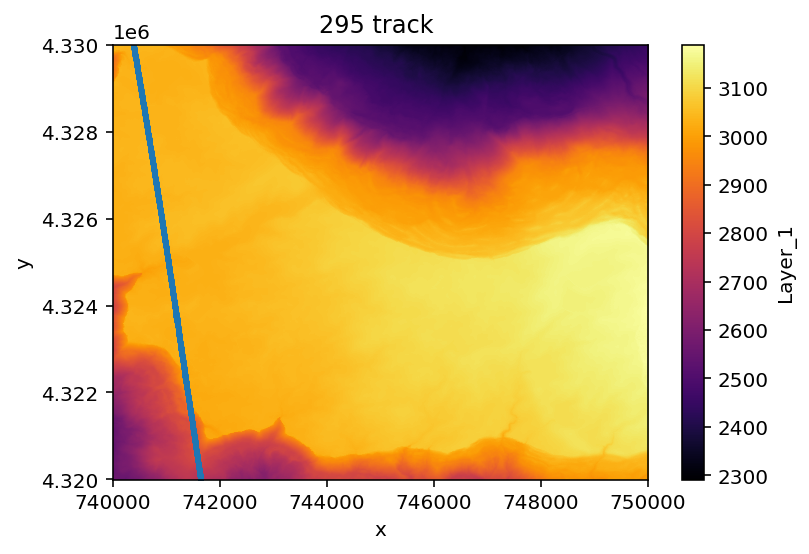

In [37]:
f,ax = plt.subplots() 
da.sel(band=1).plot.imshow(ax=ax,cmap='inferno')
x0=np.array(da.x)
y0=np.array(da.y)

for dt, day_data in IS2_data.items():
    for beam, D in day_data.items():
        if (int(dt[1]) == 295) & (dt[0] == '2020-07-14'):
            X = D['x_ph']
            Y = D['y_ph']
            Z = D['h_ph']
            x = np.ma.masked_outside(X,np.min(x0),np.max(x0))
            y = np.ma.masked_outside(Y,np.min(y0),np.max(y0))
            ax.plot(x,y, '.', markersize=3, label=dt[0])
        
        else:
            continue
ax.set_title('295 track ')

In [114]:
#https://github.com/uw-cryo/skysat_stereo
def mapToPixel(mX, mY, geoTransform):
    """Convert map coordinates to pixel coordinates based on geotransform
    
    Accepts float or NumPy arrays
    GDAL model used here - upper left corner of upper left pixel for mX, mY (and in GeoTransform)
    """
    mX = np.asarray(mX)
    mY = np.asarray(mY)
    if geoTransform[2] + geoTransform[4] == 0:
        pX = ((mX - geoTransform[0]) / geoTransform[1]) - 0.5
        pY = ((mY - geoTransform[3]) / geoTransform[5]) - 0.5
    else:
        pX, pY = applyGeoTransform(mX, mY, invertGeoTransform(geoTransform))
    #return int(pX), int(pY)
    return pX, pY

def sample_ndimage(dem_ma,dem_gt,map_x,map_y,r='bilinear'):
    """
    sample values from the dem masked array for the points in map_x, map_y coordinates
    dem_ma: Masked numpy array, prefer the dem to be conitnous though
    gt: geotransform of dem/input array
    map_x: x_coordinate array
    map_y: y_coordinate array
    r: resampling algorithm for decimal px location
    out: array containing sampled values at zip(map_y,map_x)
    """
    import scipy.ndimage
    #convert map points to px points using geotransform information
    img_x,img_y = mapToPixel(map_x,map_y,dem_gt)
    #prepare input for sampling function
    yx = np.array([img_y,img_x])
    # sample the array
    sampled_pts = scipy.ndimage.map_coordinates(dem_ma, yx, order=1,mode='nearest')
    return sampled_pts

In [146]:
#### prepare for sampling from LiDAR DEM
gdal_url = '/vsicurl/'+url
from osgeo import gdal
gdal_ds = gdal.Open(gdal_url)
band = gdal_ds.GetRasterBand(1)
dem_ma = band.ReadAsArray()
dem_gt = gdal_ds.GetGeoTransform()

In [86]:
### Try Phillip Arndt's example from here: https://github.com/fliphilipp/pondpicking

class dataCollector:
    def __init__(self, beam=None, oaurl=None, track=None, date=None, latlims=None, lonlims=None):
        if (beam is None) or ((oaurl is None) and (None in [track, date, latlims, lonlims])):
            raise Exception('''Please specify a beam and 
            - either: an OpenAltimetry API url, 
            - or: a track, date, latitude limits and longitude limits.''')
        else:
            if oaurl is not None:
                url = oaurl
                tofind = '&beamName='
                ids = url.find(tofind)
                while ids>-1:
                    url = url.replace(url[ids:ids+len(tofind)+4],'')
                    ids = url.find(tofind)
                iprod = url.find('/atl')
                url = url.replace(url[iprod:iprod+6],'/atlXX')
                url += tofind + beam + '&client=jupyter'

                idate = url.find('date=') + len('date=')
                date = url[idate:idate+10]
                itrack = url.find('trackId=') + len('trackId=')
                trackend = url[itrack:].find('&')
                track = int(url[itrack:itrack+trackend])
                bb = []
                for s in ['minx=', 'maxx=', 'miny=', 'maxy=']:
                    ids = url.find(s) + len(s)
                    ide = url[ids:].find('&')
                    bb.append(float(url[ids:ids+ide]))
                lonlims = bb[:2]
                latlims = bb[2:]
            elif None not in [track, date, latlims, lonlims]:
                url = 'https://openaltimetry.org/data/api/icesat2/atlXX?'
                url += 'date={date}&minx={minx}&miny={miny}&maxx={maxx}&maxy={maxy}&trackId={track}&beamName={beam}'.format(
                        date=date,minx=lonlims[0],miny=latlims[0],maxx=lonlims[1],maxy=latlims[1],track=track,beam=beam)
                url += '&outputFormat=json&client=jupyter'
            
            self.url = url
            self.date = date
            self.track = track
            self.beam = beam
            self.latlims = latlims
            self.lonlims = lonlims
            print('OpenAltimetry API URL:', self.url)
            print('Date:', self.date)
            print('Track:', self.track)
            print('Beam:', self.beam)
            print('Latitude limits:', self.latlims)
            print('Longitude limits:', self.lonlims)
            
    def requestData(self):
        import pandas as pd
        import json
        import requests
        
        print('---> requesting ATL03 data...',end='')
        product = 'atl03'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        lat, lon, h, confs = [], [], [], []
        for beam in data:
            for confidence in beam['series']:
                for p in confidence['data']:
                    confs.append(confidence['name'])
                    lat.append(p[0])
                    lon.append(p[1])
                    h.append(p[2])
        self.atl03 = pd.DataFrame(list(zip(lat,lon,h,confs)), columns = ['lat','lon','h','conf'])
        print(' Done.')
        
        print('---> requesting ATL06 data...',end='')
        product = 'atl06'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        self.atl06 = pd.DataFrame(data['series'][0]['lat_lon_elev'], columns = ['lat','lon','h'])
        print(' Done.')
        
        print('---> requesting ATL08 data...',end='')
        product = 'atl08'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        self.atl08 = pd.DataFrame(data['series'][0]['lat_lon_elev_canopy'], columns = ['lat','lon','h','canopy'])
        print(' Done.')

#### Download ATL03 and ATL08 just for RGT 295, Cycle 8

In [87]:
track1 = dataCollector(beam='gt2l',track=295,date='2020-07-14',
                       latlims=latlims,
                       lonlims=lonlims)

OpenAltimetry API URL: https://openaltimetry.org/data/api/icesat2/atlXX?date=2020-07-14&minx=-108.408343209786&miny=38.80833384091803&maxx=-107.90953763121124&maxy=39.18014315670584&trackId=295&beamName=gt2l&outputFormat=json&client=jupyter
Date: 2020-07-14
Track: 295
Beam: gt2l
Latitude limits: [38.80833384091803, 39.18014315670584]
Longitude limits: [-108.408343209786, -107.90953763121124]


In [88]:
track1.requestData()

---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.


In [89]:
track1.atl08

lat         lon          h     canopy
0    38.808609 -108.185928  1629.6594  19.130860
1    38.809509 -108.186035  1611.2310  17.611084
2    38.810406 -108.186157  1611.4000  15.798096
3    38.811306 -108.186279  1616.0219  10.588379
4    38.812202 -108.186401  1620.6072   9.704956
..         ...         ...        ...        ...
294  39.176414 -108.232048  1782.4597   8.688843
295  39.177315 -108.232147  1771.4846   7.619629
296  39.178211 -108.232254  1749.4400   9.416748
297  39.179111 -108.232346  1716.5808  11.158325
298  39.180012 -108.232452  1694.7723  16.497192

[299 rows x 4 columns]

In [44]:
type(track1.atl08)

pandas.core.frame.DataFrame

### Transform the ATL08 points to NAD83+NAVD88

In [90]:
points08_depcrs = []
points08 = list(zip(track1.atl08.lat, track1.atl08.lon, track1.atl08.h))

points03_depcrs = []
points03 = list(zip(track1.atl03.lat, track1.atl03.lon, track1.atl03.h))

In [91]:
for pt in to_dep_crs.itransform(points08):
    points08_depcrs.append(pt)

In [92]:
for pt in to_dep_crs.itransform(points03):
    points03_depcrs.append(pt)

In [94]:
len(points03_depcrs)

51732

In [74]:
points_depcrs[0:5]

[(744351.7852442558, 4299300.486922209, 1646.3320600628333),
 (744339.4306856167, 4299400.127730881, 1627.900153589025),
 (744325.7641943491, 4299499.304319189, 1628.0656718208281),
 (744312.0848668132, 4299598.904346604, 1632.6840793870879),
 (744298.4187894162, 4299698.080977609, 1637.2659062932419)]

In [95]:
x08 = [x_tuple[0] for x_tuple in points08_depcrs]
y08 = [y_tuple[1] for y_tuple in points08_depcrs]
z08 = [z_tuple[2] for z_tuple in points08_depcrs]

x03 = [x_tuple[0] for x_tuple in points03_depcrs]
y03 = [y_tuple[1] for y_tuple in points03_depcrs]
z03 = [z_tuple[2] for z_tuple in points03_depcrs]

#### Convert into geodataframe and subset to bounds of DEM

In [101]:
x0 = da.x
y0 = da.y

In [97]:
da

In [98]:
x0

<xarray.DataArray 'x' (x: 10012)>
array([739994.5, 739995.5, 739996.5, ..., 750003.5, 750004.5, 750005.5])
Coordinates:
  * x            (x) float64 7.4e+05 7.4e+05 7.4e+05 ... 7.5e+05 7.5e+05 7.5e+05
    spatial_ref  int64 0

In [109]:
### ATL08
atl08_gdf = gpd.GeoDataFrame(
    track1.atl08, 
    geometry=gpd.points_from_xy(x08,y08),
    crs='EPSG:6341+5703')
atl08_gdf['z'] = z08
#atl08_gdf = atl08_gdf.to_crs(dep_crs)
atl08_gdf.total_bounds
atl08_gdf_bound = atl08_gdf.cx[np.min(x0):np.max(x0),np.min(y0):np.max(y0)]


### ATL03
atl03_gdf =  gpd.GeoDataFrame(
    track1.atl03, 
    geometry=gpd.points_from_xy(x03,y03),
    crs='EPSG:6341+5703')
atl03_gdf['z'] = z03
#atl03_gdf = atl03_gdf.to_crs(dep_crs)
atl03_gdf_bound = atl03_gdf.cx[np.min(x0):np.max(x0),np.min(y0):np.max(y0)]


In [57]:
# ### ATL08
# atl08_gdf = gpd.GeoDataFrame(
#     track1.atl08, 
#     geometry=gpd.points_from_xy(track1.atl08.lon, track1.atl08.lat),
#     crs='EPSG:4326')
# atl08_gdf = atl08_gdf.to_crs(dep_crs)
# atl08_gdf.total_bounds
# atl08_gdf_bound = atl08_gdf.cx[np.min(x0):np.max(x0),np.min(y0):np.max(y0)]

# ### ATL03
# atl03_gdf =  gpd.GeoDataFrame(
#     track1.atl03, 
#     geometry=gpd.points_from_xy(track1.atl03.lon, track1.atl03.lat),
#     crs='EPSG:4326')
# atl03_gdf = atl03_gdf.to_crs(dep_crs)
# atl03_gdf_bound = atl03_gdf.cx[np.min(x0):np.max(x0),np.min(y0):np.max(y0)]

In [82]:
atl08_gdf

lat         lon          h     canopy  \
0    38.808609 -108.185928  1629.6594  19.130860   
1    38.809509 -108.186035  1611.2310  17.611084   
2    38.810406 -108.186157  1611.4000  15.798096   
3    38.811306 -108.186279  1616.0219  10.588379   
4    38.812202 -108.186401  1620.6072   9.704956   
..         ...         ...        ...        ...   
294  39.176414 -108.232048  1782.4597   8.688843   
295  39.177315 -108.232147  1771.4846   7.619629   
296  39.178211 -108.232254  1749.4400   9.416748   
297  39.179111 -108.232346  1716.5808  11.158325   
298  39.180012 -108.232452  1694.7723  16.497192   

                           geometry            z  
0    POINT (744351.785 4299300.487)  1646.332060  
1    POINT (744339.431 4299400.128)  1627.900154  
2    POINT (744325.764 4299499.304)  1628.065672  
3    POINT (744312.085 4299598.904)  1632.684079  
4    POINT (744298.419 4299698.081)  1637.265906  
..                              ...          ...  
294  POINT (739104.465 4340003.837)  1798.786872  
295  POINT (739092.844 4340103.506)  1787.815211  
296  POINT (739080.577 4340202.731)  1765.774055  
297  POINT (739069.615 4340302.420)  1732.918277  
298  POINT (739057.336 4340402.069)  1711.113234  

[299 rows x 6 columns]

Text(0.5, 1.0, '295 track ')

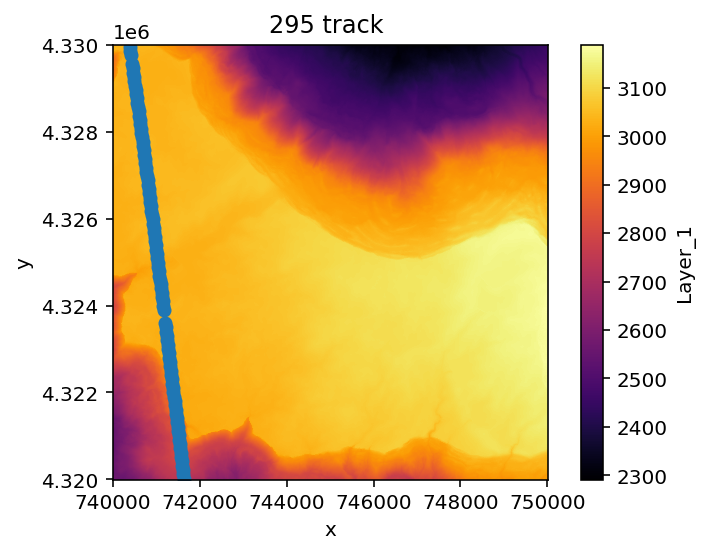

In [59]:
f,ax = plt.subplots()


da.sel(band=1).plot.imshow(ax=ax,cmap='inferno')

atl08_gdf_bound.plot(ax=ax)
ax.set_title('295 track ')

#### Sample the LiDAR DEM at ATL03 points

In [116]:
x = atl03_gdf_bound.geometry.x.values
y = atl03_gdf_bound.geometry.y.values
lidar_h = sample_ndimage(dem_ma,dem_gt,x,y)

In [117]:
da = None
dem_ma = None
dem_ds = None

In [62]:
# compare the photons near the ground, compare with photons within the window used in fitting 

In [119]:
atl08_gdf_bound.describe()

lat         lon            h     canopy            z
count  98.000000   98.000000    98.000000  77.000000    98.000000
mean   39.040548 -108.215128  2976.775726  15.652711  2992.736560
std     0.026341    0.003159    86.497706   6.346616    86.477316
min    38.995804 -108.220764  2704.160400   6.648682  2720.188741
25%    39.017605 -108.217768  3002.869075  10.833740  3018.826604
50%    39.041208 -108.215092  3015.750150  14.578369  3031.700800
75%    39.062997 -108.212404  3022.911475  16.558105  3038.852564
max    39.085670 -108.209862  3031.853500  35.493896  3047.793808

In [106]:
lidar_h.mean()

3001.679

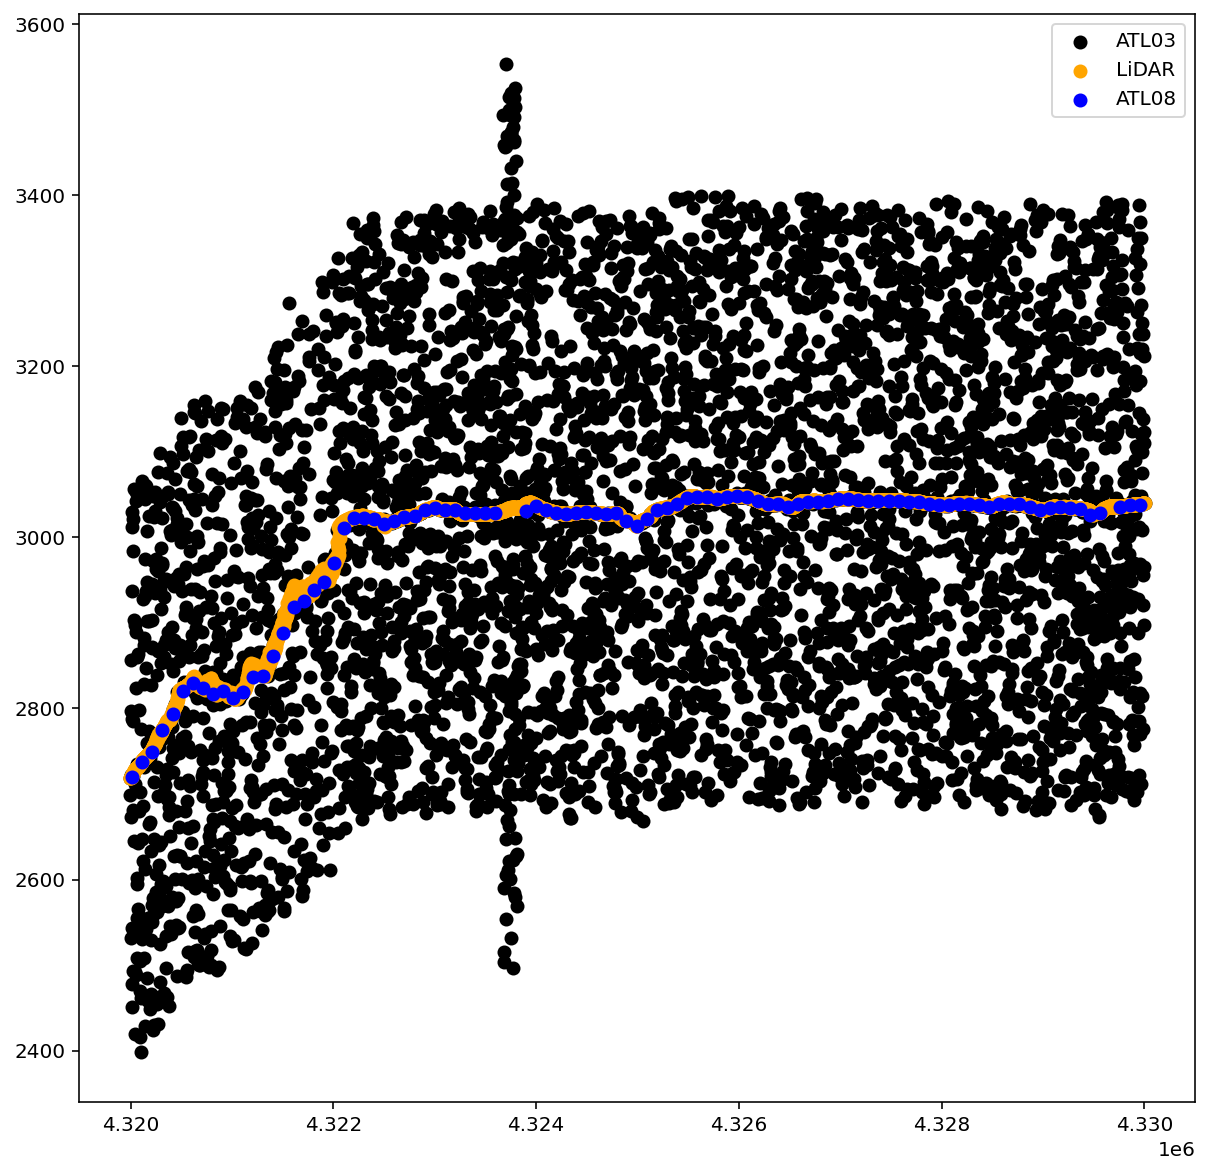

In [133]:
f,ax = plt.subplots(figsize=(10,10))
ax.scatter(atl03_gdf_bound.geometry.y,atl03_gdf_bound.z,c='k',label='ATL03')
ax.scatter(atl03_gdf_bound.geometry.y,lidar_h,c='orange',label='LiDAR')
ax.scatter(atl08_gdf_bound.geometry.y,atl08_gdf_bound.z,c='blue',label='ATL08')
ax.legend()

#### SlideRule
###### From Ben's tutorial

In [204]:
! [ -d sliderule-python ] || git clone https://github.com/ICESat2-SlideRule/sliderule-python.git 
#! cd sliderule-python; python setup.py develop
! cd sliderule-python; python setup.py install

running install
running bdist_egg
running egg_info
writing sliderule.egg-info/PKG-INFO
writing dependency_links to sliderule.egg-info/dependency_links.txt
writing requirements to sliderule.egg-info/requires.txt
writing top-level names to sliderule.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'sliderule.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib

creating build
creating build/bdist.macosx-10.9-x86_64
creating build/bdist.macosx-10.9-x86_64/egg
creating build/bdist.macosx-10.9-x86_64/egg/EGG-INFO
installing scripts to build/bdist.macosx-10.9-x86_64/egg/EGG-INFO/scripts
running install_scripts
running build_scripts
creating build/scripts-3.8
copying utils/query_services.py -> build/scripts-3.8
copying utils/monitor.py -> build/scripts-3.8
copying utils/extract_h5_dataset.py -> build/scripts-3.8
copying utils/region_of_interest.py -> build/scripts-3.8
copying utils/query_version.py -> build

In [120]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/SnowEx_Hackweek_2021/integration_station/contributors/shashank


In [205]:
import sliderule
from sliderule import icesat2

In [123]:
latlims

[38.80833384091803, 39.18014315670584]

In [149]:
icesat2.CNF_SURFACE_MEDIUM

3

In [209]:
def fetch_atl06sliderule(latlims = latlims,lonlims = lonlims,len=20,res=len,cnf=icesat2.CNF_SURFACE_MEDIUM):
    from sliderule import icesat2

    # initialize
    icesat2.init("icesat2sliderule.org", verbose=False)

    # region of interest polygon
    region = [ {"lon":lon_i, "lat":lat_i} for lon_i, lat_i in 
              zip(np.array(lonlims)[[0, -1, -1, 0, 0]],  np.array(latlims)[[0, 0, -1, -1, 0]])]

    # request parameters
    params = {
        "poly": region,  # request the polygon defined by our lat-lon bounds
        "srt": icesat2.SRT_LAND, # request classification based on the land algorithm
        "cnf": cnf, # use all photons of low confidence or better
        "len": len,  # fit data in overlapping len-meter segments
        "res": res,  # report one height every res m
        "ats":5., #report a segment only if it contains at least 2 photons separated by 5 m
        "maxi": 6,  # allow up to six iterations in fitting each segment to the data
        "spot": 'beam (like gt1r --> spot 1,2,3,4..)'
    }

    # make request
    rsps = icesat2.atl06p(params, "atlas-s3")

    # save the result in a dataframe
    df = pd.DataFrame(rsps)

    # calculate the polar-stereographic coordinates:
    #df['x'], df['y']=to_image_crs.transform(df['lat'], df['lon'])
    # mask for selcting cycle 295
    mask = df.rgt == 295
    atl06_295 = df[mask]
    # mask for rgt 8
    mask = atl06_295['cycle'] == 8
    atl06_295 = atl06_295[mask]
    points_atl06_295 = []
    points06 = list(zip(atl06_295.lat, atl06_295.lon, atl06_295.h_mean))
    for pt in to_dep_crs.itransform(points06):
        points_atl06_295.append(pt)
    x06 = [x_tuple[0] for x_tuple in points_atl06_295]
    y06 = [y_tuple[1] for y_tuple in points_atl06_295]
    z06 = [z_tuple[2] for z_tuple in points_atl06_295]
    atl06_295_gdf = gpd.GeoDataFrame(
    atl06_295, 
    geometry=gpd.points_from_xy(x06, y06),
    crs='EPSG:6341+5703')
    atl06_295_gdf['z'] = z06
    #atl06_295_gdf = atl06_295_gdf.to_crs('EPSG:32612')
    # clip to bounds
    atl06_295_gdf_bound = atl06_295_gdf.cx[np.min(x0):np.max(x0),np.min(y0):np.max(y0)]
    return atl06_295_gdf_bound

TypeError: unsupported operand type(s) for /: 'builtin_function_or_method' and 'int'

In [216]:
#Attempt to access ATL08-like data from sliderule

def fetch_atl08sliderule(latlims = latlims, lonlims = lonlims, len=20, res=len, \
                         cnf=icesat2.CNF_SURFACE_MEDIUM, atl08_class="atl08_canopy"):
    from sliderule import icesat2

    # initialize
    icesat2.init("icesat2sliderule.org", verbose=False)

    # region of interest polygon
    region = [ {"lon":lon_i, "lat":lat_i} for lon_i, lat_i in 
              zip(np.array(lonlims)[[0, -1, -1, 0, 0]],  np.array(latlims)[[0, 0, -1, -1, 0]])]

    # request parameters
    params = {
        "poly": region,  # request the polygon defined by our lat-lon bounds
        "srt": icesat2.SRT_LAND, # request classification based on the land algorithm
        "cnf": cnf, # use all photons of low confidence or better
        "len": len,  # fit data in overlapping len-meter segments
        "res": res,  # report one height every res m
        "ats":5., #report a segment only if it contains at least 2 photons separated by 5 m
        "maxi": 6,  # allow up to six iterations in fitting each segment to the data
        "spot": 'beam (like gt1r --> spot 1,2,3,4..)'
    }

    # make request
    rsps = icesat2.atl06p(params, "atlas-s3")

    # save the result in a dataframe
    df = pd.DataFrame(rsps)

    # calculate the polar-stereographic coordinates:
    #df['x'], df['y']=to_image_crs.transform(df['lat'], df['lon'])
    # mask for selcting cycle 295
    mask = df.rgt == 295
    atl06_295 = df[mask]
    # mask for rgt 8
    mask = atl06_295['cycle'] == 8
    atl06_295 = atl06_295[mask]
    points_atl06_295 = []
    points06 = list(zip(atl06_295.lat, atl06_295.lon, atl06_295.h_mean))
    for pt in to_dep_crs.itransform(points06):
        points_atl06_295.append(pt)
    x06 = [x_tuple[0] for x_tuple in points_atl06_295]
    y06 = [y_tuple[1] for y_tuple in points_atl06_295]
    z06 = [z_tuple[2] for z_tuple in points_atl06_295]
    atl06_295_gdf = gpd.GeoDataFrame(
    atl06_295, 
    geometry=gpd.points_from_xy(x06, y06),
    crs='EPSG:6341+5703')
    atl06_295_gdf['z'] = z06
    #atl06_295_gdf = atl06_295_gdf.to_crs('EPSG:32612')
    # clip to bounds
    atl06_295_gdf_bound = atl06_295_gdf.cx[np.min(x0):np.max(x0),np.min(y0):np.max(y0)]
    return atl06_295_gdf_bound

In [199]:
icesat2.atl06?

Signature: icesat2.atl06(parm, resource, asset='atlas-s3', track=0, as_numpy=False)
Docstring: <no docstring>
File:      ~/Documents/Documents_Grad/Research/SnowEx_Hackweek_2021/integration_station/contributors/shashank/sliderule/icesat2.py
Type:      function


In [174]:
# fetch using default parame
sliderule_len20_res10 = fetch_atl06sliderule()

In [164]:
df['rgt'].unique()

array([1156,  295,  737, 1179,  211])

In [165]:
df.rgt

0         1156
1         1156
2         1156
3         1156
4         1156
          ... 
328979     737
328980     737
328981     737
328982     737
328983     737
Name: rgt, Length: 328984, dtype: int64

In [152]:
sliderule_len20_res10.head(5)

__rectype    delta_time       h_mean  n_fit_photons  pflags  \
270758  atl06rec.elevation  7.997820e+07  2897.896589             10       0   
270759  atl06rec.elevation  7.997820e+07  3032.277753             10       0   
270760  atl06rec.elevation  7.997820e+07  3032.482083             14       0   
270761  atl06rec.elevation  7.997820e+07  3034.070268             14       0   
270762  atl06rec.elevation  7.997820e+07  3034.320525             20       0   

        rgt  spot  dh_fit_dx  w_surface_window_final  gt  dh_fit_dy  \
270758  295     1   0.339386                8.675927  50        0.0   
270759  295     1   0.021634                3.000000  50        0.0   
270760  295     1   0.016506                3.000000  50        0.0   
270761  295     1   0.026298                3.000000  50        0.0   
270762  295     1   0.031840                3.000000  50        0.0   

        segment_id         lon   h_sigma  cycle  rms_misfit        lat  \
270758      216298 -108.173185  0.055787      8    0.166012  38.998135   
270759      216311 -108.173506  0.116648      8    0.184507  39.000559   
270760      216312 -108.173516  0.047999      8    0.168336  39.000649   
270761      216313 -108.173536  0.054072      8    0.127824  39.000829   
270762      216313 -108.173547  0.061400      8    0.269869  39.000919   

                              geometry            z  
270758  POINT (744806.201 4320371.622)  2913.802240  
270759  POINT (744770.034 4320639.880)  3048.172206  
270760  POINT (744768.859 4320649.813)  3048.376309  
270761  POINT (744766.445 4320669.716)  3049.964041  
270762  POINT (744765.247 4320679.692)  3050.214071

In [127]:
sliderule_len20_res10['spot'].unique()

array([3, 4, 1, 2])

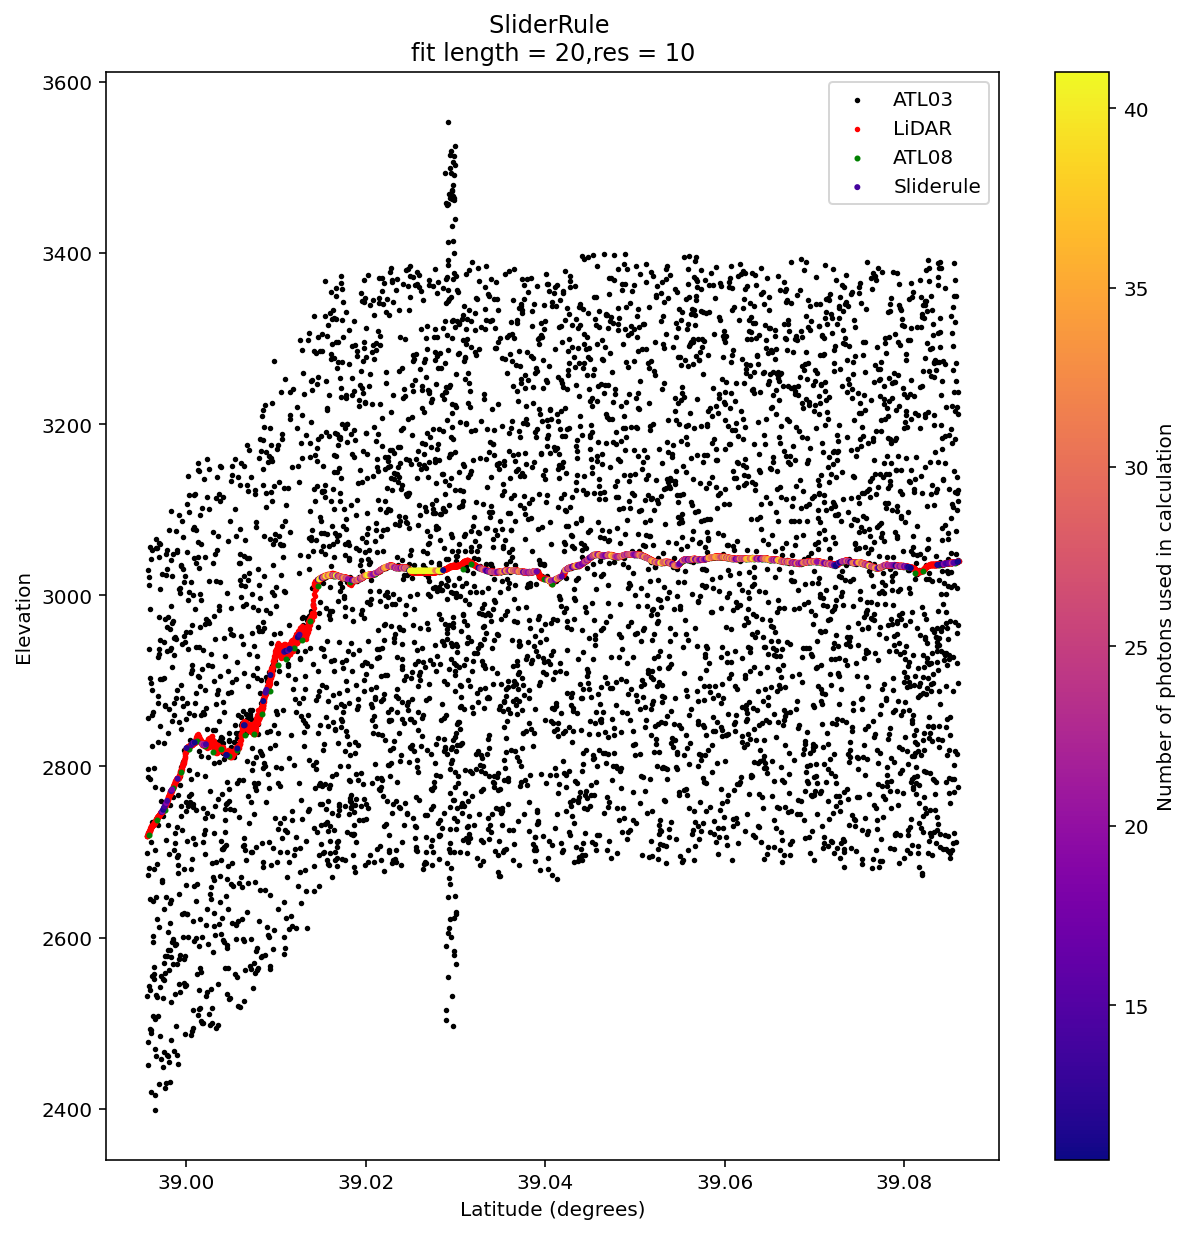

In [139]:
f,ax = plt.subplots(figsize=(10,10))
ms = 3
length = 20
res = 10
ax.set_title(f'SliderRule \nfit length = {length},res = {res}')
mask = sliderule_len20_res10['spot'] == 3
slide_reduced = sliderule_len20_res10[mask]
clim = np.percentile(sliderule_len20_res10['n_fit_photons'].values,(5,95))
ax.scatter(atl03_gdf_bound.lat,atl03_gdf_bound.z,c='k',label='ATL03',s=ms)
ax.scatter(atl03_gdf_bound.lat,lidar_h,c='r',label='LiDAR',s=ms)
ax.scatter(atl08_gdf_bound.lat,atl08_gdf_bound.z,c='g',label='ATL08',s=4)
im = ax.scatter(slide_reduced.lat,slide_reduced.z,label='Sliderule',
          s=4,c=slide_reduced['n_fit_photons'],cmap='plasma',
               vmin=clim[0],vmax=clim[1])
plt.colorbar(im,ax=ax,label='Number of photons used in calculation')
ax.set_xlabel('Latitude (degrees)')
ax.set_ylabel('Elevation')
ax.legend()

In [ ]:
sliderule_len20_res10.describe()

#### Test different fit parameters

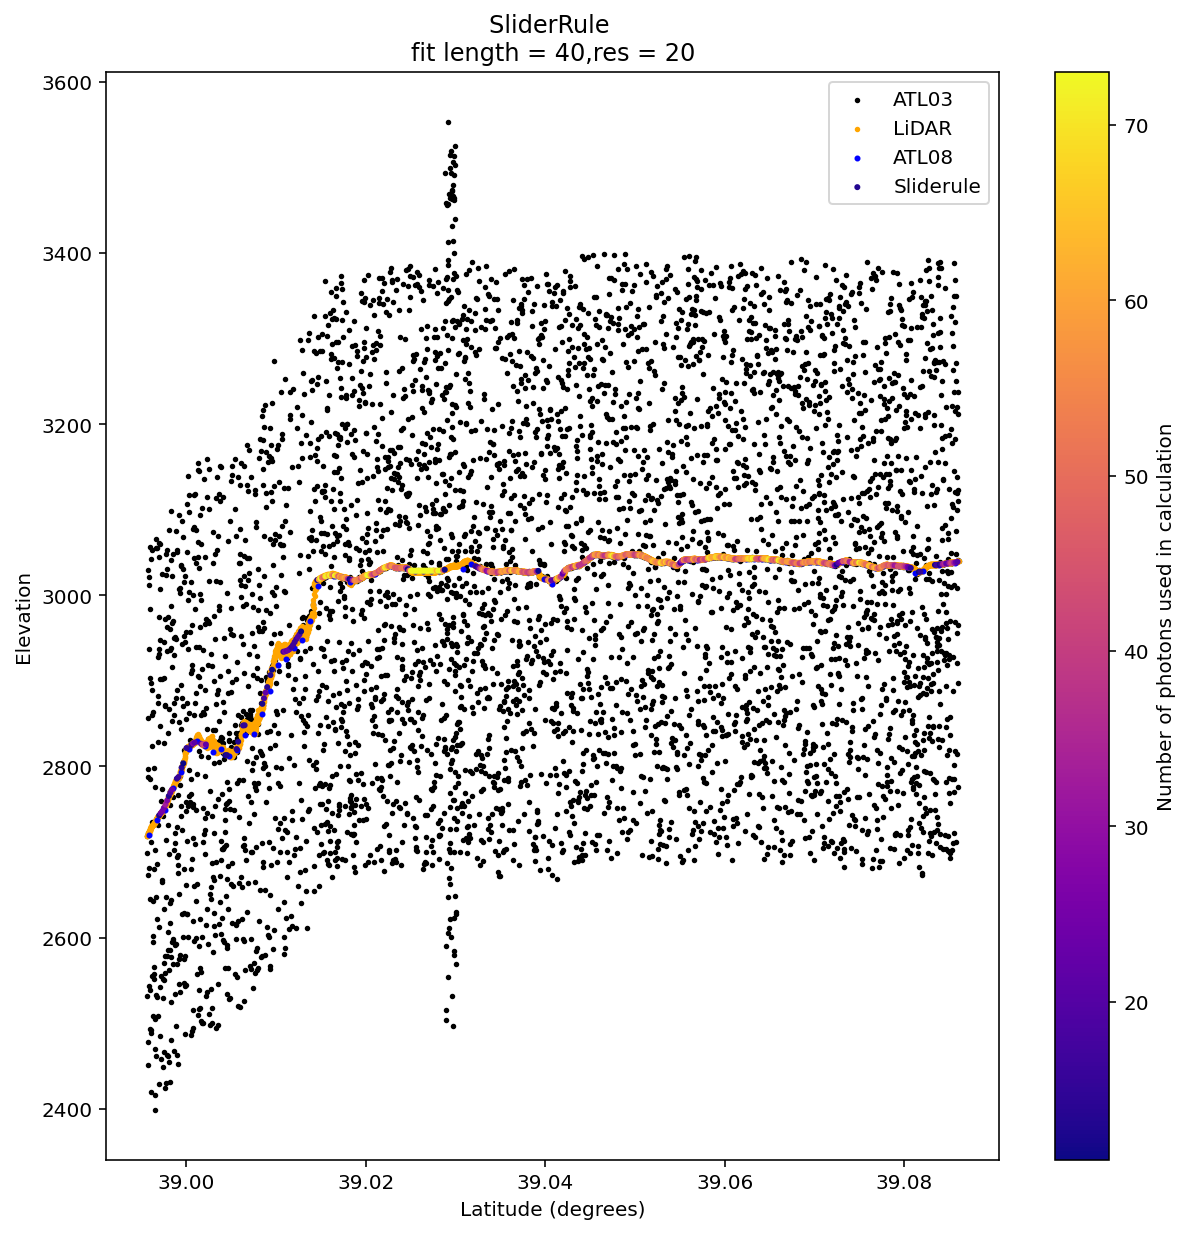

In [140]:
f,ax = plt.subplots(figsize=(10,10))
ms = 3
length = 40
res = 20
sliderule_len20_res10 = fetch_sliderule(len=length,res=res)
ax.set_title(f'SliderRule \nfit length = {length},res = {res}')
mask = sliderule_len20_res10['spot'] == 3
slide_reduced = sliderule_len20_res10[mask]
clim = np.percentile(sliderule_len20_res10['n_fit_photons'].values,(5,95))
ax.scatter(atl03_gdf_bound.lat,atl03_gdf_bound.z,c='k',label='ATL03',s=ms)
ax.scatter(atl03_gdf_bound.lat,lidar_h,c='orange',label='LiDAR',s=ms)
ax.scatter(atl08_gdf_bound.lat,atl08_gdf_bound.z,c='blue',label='ATL08',s=4)
im = ax.scatter(slide_reduced.lat,slide_reduced.z,label='Sliderule',
          s=4,c=slide_reduced['n_fit_photons'],cmap='plasma',
               vmin=clim[0],vmax=clim[1])
plt.colorbar(im,ax=ax,label='Number of photons used in calculation')
ax.set_xlabel('Latitude (degrees)')
ax.set_ylabel('Elevation')
ax.legend()

## more to do and indepth exploration required

In [ ]:
## http://icesat2sliderule.org/rtd/user_guide/ICESat-2.html

In [141]:
import numpy as np

def RDE(x):
    xs=x.copy()
    xs=np.isfinite(xs)   # this changes xs from values to a boolean
    if np.sum(xs)<2 :
        return np.nan
    ind=np.arange(0.5, np.sum(xs))
    LH=np.interp(np.array([0.16, 0.84])*np.sum(xs), ind, np.sort(x[xs]))
    #print('LH =',LH)
    return (LH[1]-LH[0])/2.  # trying to get some kind of a width of the data ~variance

CRITICAL:sliderule.sliderule:http://52.88.249.188:9081 encountered consecutive error 1


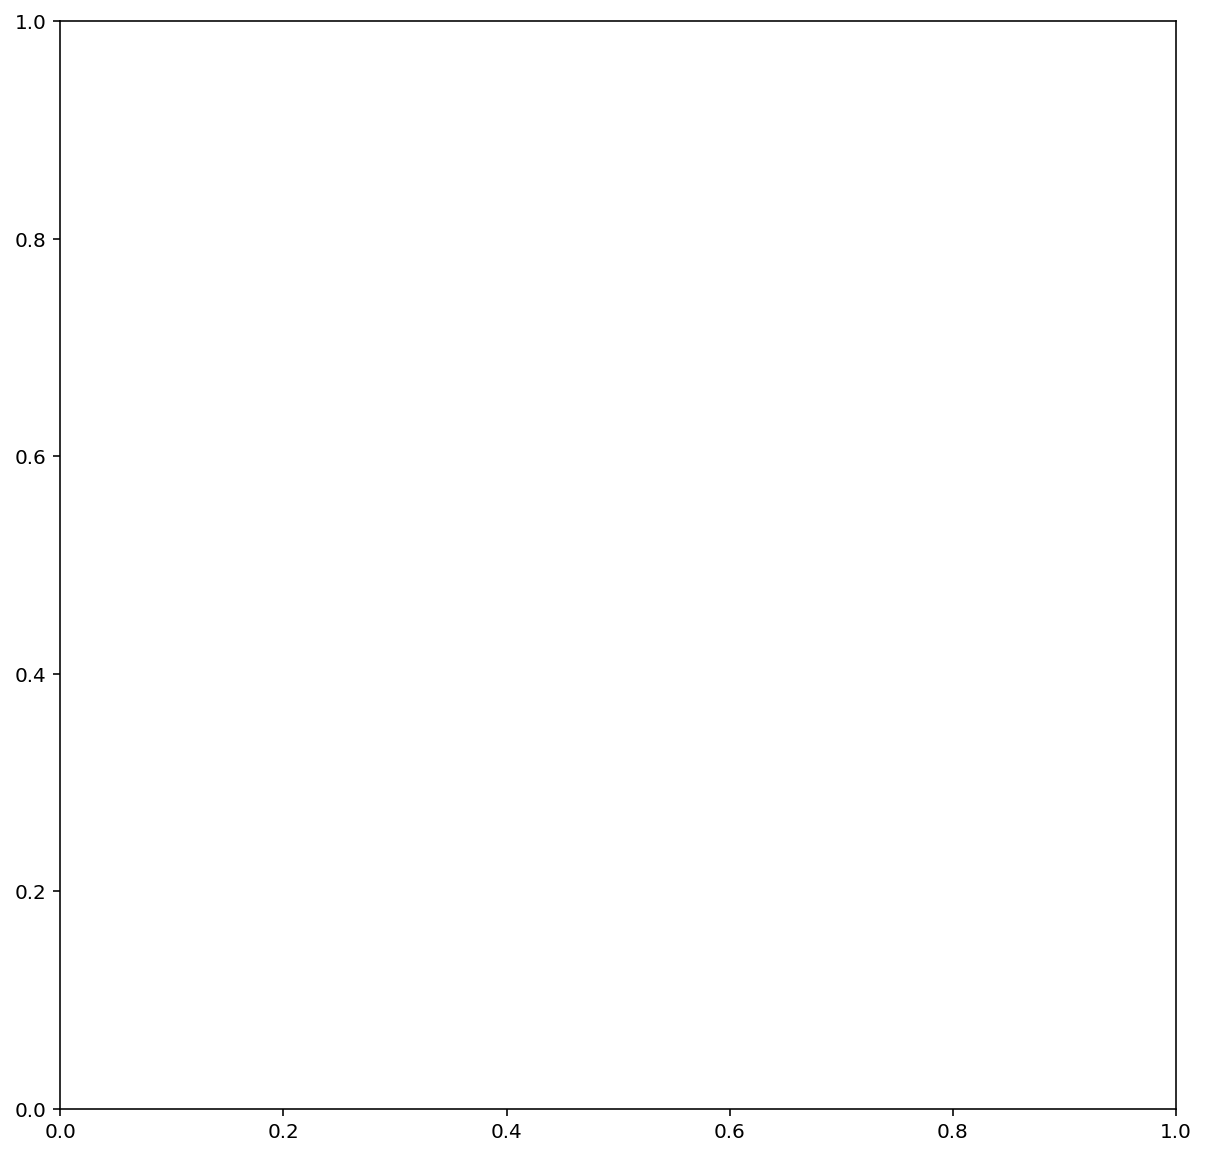

In [176]:
ms = 3
length = [5,10,20,40,80]
#res = [2.5,5,10,20,40]
c_val=[2,3,4]
sigma=np.zeros((3, 5))
for iL, L in enumerate(length):
    for ic, cnf in enumerate(c_val):
        thefile = f'atl06_gdf_L{L}_cnf{cnf}'
        D0 = fetch_sliderule(len=L,cnf=cnf)
        x = D0.geometry.x.values
        y = D0.geometry.y.values
        lidar_h = sample_ndimage(dem_ma,dem_gt,x,y)
        sigma[ic, iL] = RDE(D0.z-lidar_h)
        thefile = D0
            
#sliderule_len20_res10 = fetch_sliderule(len=length,res=res)

In [181]:
atl06 = {'Length10':{'cnf3':,'cnf4':},
        'Length20':{'cnf3':,'cnf4':}}

SyntaxError: invalid syntax (<ipython-input-181-816aa2ee53ca>, line 1)

In [180]:

length = [10,20,40]
c_val=[3,4]

for key1, key2 in zip(length, c_val):
    atl06[key1] = dict([key2])

TypeError: cannot convert dictionary update sequence element #0 to a sequence

In [183]:
atl06 = {}
ms = 3
length = [10,20,40]
c_val=[3,4]

for L in enumerate(length):
    for cnf in enumerate(c_val):
        atl06[f'L{L}']={}
        atl06[f'L{L}'][f'cnf{cnf}']={}

In [188]:
atl06 = {}
ms = 3
length = [10,20,40]
c_val=[3,4]

for L in length:
    for cnf in c_val:
        atl06[f'L{L}']={}
        atl06[f'L{L}'][f'cnf{cnf}']={}

In [186]:
atl06

{'L10': {'cnf4': {}}, 'L20': {'cnf4': {}}, 'L40': {'cnf4': {}}}

In [184]:
atl06

{'L(0, 10)': {'cnf(1, 4)': {}},
 'L(1, 20)': {'cnf(1, 4)': {}},
 'L(2, 40)': {'cnf(1, 4)': {}}}

In [198]:
# Use this for ATL06:

ms = 3
length = [10,20,40]
c_val=[2,3,4]
sigma_06=np.zeros((3, 3))
for iL, L in enumerate(length):
    for ic, cnf in enumerate(c_val):
        atl06[f'L{L}'][f'cnf{cnf}'] = fetch_atl06sliderule(len=L,cnf=cnf)
        x = atl06[f'L{L}'][f'cnf{cnf}'].geometry.x.values
        y = atl06[f'L{L}'][f'cnf{cnf}'].geometry.y.values
        lidar_h = sample_ndimage(dem_ma,dem_gt,x,y)
        sigma_06[ic, iL] = RDE(atl06[f'L{L}'][f'cnf{cnf}'].z-lidar_h)

In [192]:
atl06

{'L10': {'cnf4':                 __rectype    delta_time       h_mean  n_fit_photons  pflags  \
  91976  atl06rec.elevation  7.997820e+07  3050.067939             15       0   
  91977  atl06rec.elevation  7.997820e+07  3050.407876             18       0   
  91978  atl06rec.elevation  7.997820e+07  3050.338230             10       0   
  91979  atl06rec.elevation  7.997820e+07  3050.738355             14       0   
  91980  atl06rec.elevation  7.997820e+07  3054.895031             14       0   
  ...                   ...           ...          ...            ...     ...   
  92590  atl06rec.elevation  7.997820e+07  3021.236860             11       0   
  92591  atl06rec.elevation  7.997820e+07  3021.530121             10       0   
  92592  atl06rec.elevation  7.997820e+07  3021.754244             10       0   
  92593  atl06rec.elevation  7.997820e+07  3021.895003             11       0   
  92594  atl06rec.elevation  7.997820e+07  3022.043644             10       0   
  
         r

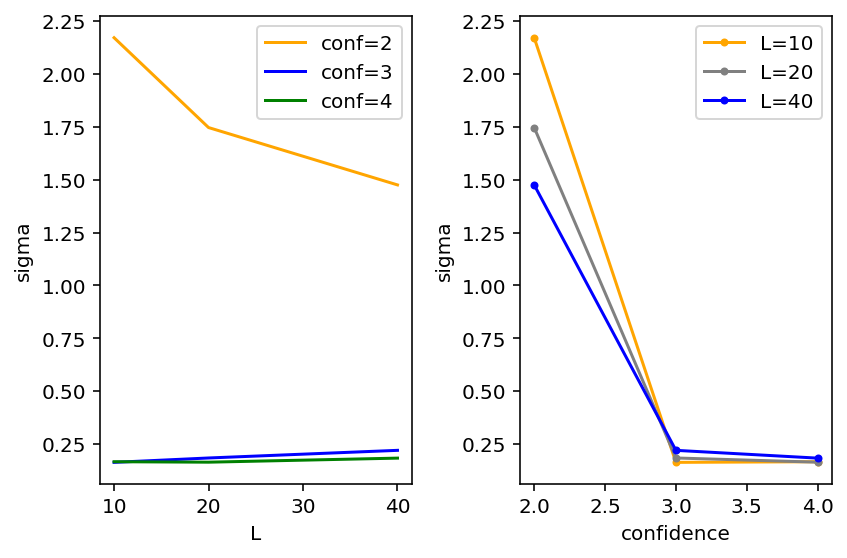

In [200]:
c_colors={2:'orange',3:'blue',4:'green'}
L_colors={10:'orange', 20:'gray', 40:'blue'}
hfig=plt.figure()
hax=hfig.subplots(1,2)

plt.sca(hax[0]);
for ic, cnf in enumerate(c_val):
    plt.plot(length, sigma_06[ic,:], label=f'conf={cnf}', color=c_colors[cnf])
plt.legend()
plt.gca().set_xlabel('L')
plt.gca().set_ylabel('sigma')

plt.sca(hax[1]); 
for iL, L in enumerate(length):
    plt.plot(c_val, sigma_06[:,iL], label=f'L={L}', color=L_colors[L], marker='.')
plt.legend()
plt.gca().set_xlabel('confidence')
plt.gca().set_ylabel('sigma')
plt.tight_layout();

In [221]:
# Use this for ATL08 ground returns:
atl08 = {}
ms = 3
length = [5,10,20,40]
c_val=[3,4]
sigma_08=np.zeros((2, 4))

for L in length:
    for cnf in c_val:
        atl08[f'L{L}']={}
        atl08[f'L{L}'][f'cnf{cnf}']={}


for iL, L in enumerate(length):
    for ic, cnf in enumerate(c_val):
        atl08[f'L{L}'][f'cnf{cnf}'] = fetch_atl08sliderule(len=L,res=(L/2),cnf=cnf)
        x = atl08[f'L{L}'][f'cnf{cnf}'].geometry.x.values
        y = atl08[f'L{L}'][f'cnf{cnf}'].geometry.y.values
        lidar_h = sample_ndimage(dem_ma,dem_gt,x,y)
        sigma_08[ic, iL] = RDE(atl08[f'L{L}'][f'cnf{cnf}'].z-lidar_h)

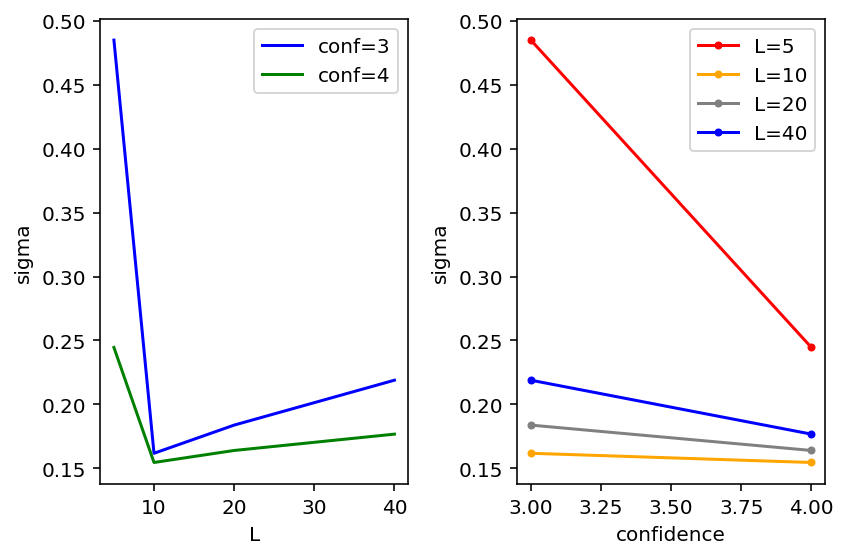

In [222]:
c_colors={3:'blue',4:'green'}
L_colors={5:'red',10:'orange', 20:'gray', 40:'blue'}
hfig=plt.figure()
hax=hfig.subplots(1,2)

plt.sca(hax[0]);
for ic, cnf in enumerate(c_val):
    plt.plot(length, sigma_08[ic,:], label=f'conf={cnf}', color=c_colors[cnf])
plt.legend()
plt.gca().set_xlabel('L')
plt.gca().set_ylabel('sigma')

plt.sca(hax[1]); 
for iL, L in enumerate(length):
    plt.plot(c_val, sigma_08[:,iL], label=f'L={L}', color=L_colors[L], marker='.')
plt.legend()
plt.gca().set_xlabel('confidence')
plt.gca().set_ylabel('sigma')
plt.tight_layout();

In [177]:
# atl06 = {}
# ms = 3
# length = [10,20,40]
# c_val=[3,4]
# sigma=np.zeros((2, 3))
# for iL, L in enumerate(length):
#     for ic, cnf in enumerate(c_val):
#         thefile = f'atl06_gdf_L{L}_cnf{cnf}'
#         D0 = fetch_sliderule(len=L,cnf=cnf)
#         x = D0.geometry.x.values
#         y = D0.geometry.y.values
#         lidar_h = sample_ndimage(dem_ma,dem_gt,x,y)
#         sigma[ic, iL] = RDE(D0.z-lidar_h)
#         thefile = D0